In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_theme()

# https://www.kaggle.com/datasets/beatafaron/fmcg-daily-sales-data-to-2022-2024

In [2]:
def read_data():
    data = pd.read_csv(r"C:\Users\flori\Documents\Github\Forecasting\data\FMCG_2022_2024.csv")
    return data

data = read_data()

# 1 Data Engineering

In [3]:
# Convert date into datetime and set as index
def convert_date(df):

    # Convert into datetime
    df["date"] = pd.to_datetime(df["date"])

    # Set as index
    df = df.set_index("date")

    # Restrict Date Range
    '''
    Some categories start later than others. Therefore the data range will be 
    restricted to the date where all categories have data.
    '''
    df = df[(df.index >= "2022-09-10") & (df.index <= "2024-12-31")]

    return df

data = convert_date(data)

In [4]:
def data_aggregating(data):

    # Sicherstellen, dass der Index ein DatetimeIndex ist
    data = data.copy()
    
    # DataFrame mit allen Tagen
    df_join = pd.DataFrame(index=pd.date_range(data.index.min(), data.index.max()))
    
    # Gesamtanzahl Transaktionen pro Tag
    sum_units_sold = data.resample("D")["units_sold"].sum()
    df_join = df_join.join(sum_units_sold.rename("Sum_units_sold"))
    
    # Kategoriale Spalten
    cat_cols = ["region", "channel", "pack_type", "promotion_flag"]
    for col in cat_cols:
        for cat in data[col].unique():
            count_cat = data[data[col] == cat].resample("D")[col].count().rename(f"Abs_{col}_{cat}")
            prop_cat = (count_cat / data.resample("D")["units_sold"].count()).rename(f"Prop_{col}_{cat}")
            # df_join = df_join.join(count_cat)
            df_join = df_join.join(prop_cat)
    

    # Numerische Spalten
    num_cols = ["price_unit", "delivery_days", "stock_available", "delivered_qty"]
    for col in num_cols:
        if col == "price_unit":
            mean_col = data.resample("D")[col].mean().rename(f"Mean_{col}")
            df_join = df_join.join(mean_col)
        else:
            sum_col = data.resample("D")[col].sum().rename(f"Sum_{col}")
            df_join = df_join.join(sum_col)
    
    return df_join

df_ml = data_aggregating(data)


In [5]:
def feature_enrichment(df):

    df = df_ml.copy()

    # Time Features
    df["Year"] = df.index.year
    df["Quarter"] = df.index.quarter
    df["Month"] = df.index.month
    df["Day"] = df.index.day
    df["DayOfWeek"] = df.index.dayofweek

    # Lag Features
    df["Lag_1"] = df["Sum_units_sold"].shift(1, fill_value = 0)
    df["Lag_7"] = df["Sum_units_sold"].shift(7, fill_value = 0)
    df["Lag_30"] = df["Sum_units_sold"].shift(30, fill_value = 0)
    df["Lag_90"] = df["Sum_units_sold"].shift(90, fill_value = 0)
    df["Lag_365"] = df["Sum_units_sold"].shift(365, fill_value = 0)
    df["Lag_730"] = df["Sum_units_sold"].shift(365*2, fill_value = 0)

    # Rolling Features
    # df["roll_1"] = df["Sum_units_sold"].shift(1).rolling(2, min_periods=1).mean()
    # df["roll_7"] = df["Sum_units_sold"].shift(1).rolling(7, min_periods=1).mean()
    # df["roll_30"] = df["Sum_units_sold"].shift(1).rolling(30, min_periods=1).mean()
    # df["roll_90"] = df["Sum_units_sold"].shift(1).rolling(90, min_periods=1).mean()
    # df["roll_365"] = df["Sum_units_sold"].shift(1).rolling(365, min_periods=1).mean()
    # df["roll_730"] = df["Sum_units_sold"].shift(1).rolling(365*2, min_periods=1).mean()

    df = df.dropna()

    return df

df_ml = feature_enrichment(df_ml)

# 4 XGBoost Regression

In [7]:
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [8]:
def data_split(df):
    ''' 
    1 week will be hold back for testing with the final model found in the cross validation
    '''
    df = df_ml.sort_index()
    date_split = df.index.max() - pd.DateOffset(weeks=1)
    
    train_data = df[df.index <= date_split]
    test_data  = df[df.index > date_split]
    
    X = train_data.drop(columns="Sum_units_sold")
    y = train_data["Sum_units_sold"]
    
    return train_data, test_data, X, y

train_data, test_data, X, y = data_split(df_ml)

print(f"Train Max Date: {train_data.index.max()}; Test Min Date: {test_data.index.min()}")
print(f"Train Set: {len(train_data)}; Test Set: {len(test_data)}")

Train Max Date: 2024-12-24 00:00:00; Test Min Date: 2024-12-25 00:00:00
Train Set: 837; Test Set: 7


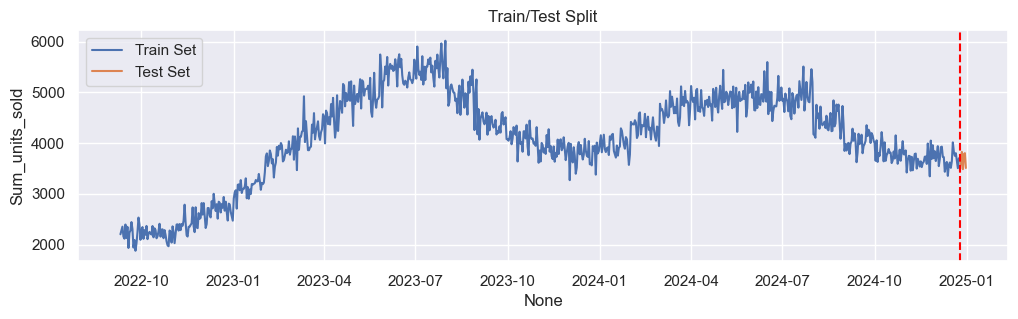

In [9]:
# Plot Train/Test Split
plt.figure(figsize=(12,3))
sns.lineplot(data=train_data, x=train_data.index, y="Sum_units_sold", errorbar=None, label="Train Set")
sns.lineplot(data=test_data, x=test_data.index, y="Sum_units_sold", errorbar=None, label="Test Set")
plt.title("Train/Test Split")
plt.axvline(test_data.index.min(), ls="--", color="red");

## 4.1 Time Series Nested Cross Validation

In [ ]:
train_score_list = []
val_score_list = []
rmse_scores = []


####### Outer Loop for Model Evaluation #######

tsp = TimeSeriesSplit(test_size=7, gap=7)

# Fit with Time Series Cross Validation 
for i, (train_idx, val_idx) in enumerate(tsp.split(train_data)):
    
    # Train/Val Split only with Train Data
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]



    ####### Inner Loop for Model Selection (Hyperparameter Search) #######

    # Instantiate Inner Time Series Split
    tsp_inner = TimeSeriesSplit(n_splits=3, gap=7, test_size=7)

    # Set Parameter Scope for Search Grid
    params = {
        "n_estimators": [500, 1000, 2000],
        "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
        "max_depth": [2, 3, 4, 5, 6]
        }

    # Instantiate XGB Regressor
    reg_cv = XGBRegressor(
        random_state=42,
        # early_stopping_rounds=20,
        eval_metric="rmse"
    )
        
    # Instantiate Search Grid CV
    gridcv = GridSearchCV(
        estimator=reg_cv,
        param_grid=params,
        cv=tsp_inner,
        scoring = "neg_root_mean_squared_error",
        n_jobs=-1
    )

    # Fit Model
    gridcv.fit(X_train, y_train)


    # Extract Best Estimator and Parameters
    best_model = gridcv.best_estimator_
    best_params = gridcv.best_params_

    # Predict
    y_pred = best_model.predict(X_val)

    # Calculate RMSE
    rmse = root_mean_squared_error(y_val, y_pred)
    rmse_scores.append(rmse)


    print(f"Fold: {i+1}")
    print(f"RMSE: {rmse}")
    print(f"Best Params: {best_params}")

Fold: 1
RMSE: 125.84375762939453
Best Params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000}
Fold: 2
RMSE: 91.67784118652344
Best Params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500}
Fold: 3
RMSE: 110.46344757080078
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000}
Fold: 4
RMSE: 123.9328384399414
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 2000}
Fold: 5
RMSE: 98.89418029785156
Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 2000}


In [17]:
# Calculate Mean RMSE across all folds
mean_rmse_score = np.sum(rmse_scores) / len(rmse_scores)
std_rmse_score = np.std(rmse_scores)
coef_of_variation = std_rmse_score / mean_rmse_score

print(rmse_scores)
print(f"Mean RMSE Score: {mean_rmse_score}")
print(f"Std of RMSE Score: {std_rmse_score}")
print(f"Coefficient of Variation: {coef_of_variation}")

[125.84375762939453, 91.67784118652344, 110.46344757080078, 123.9328384399414, 98.89418029785156]
Mean RMSE Score: 110.16241302490235
Std of RMSE Score: 13.448213794798052
Coefficient of Variation: 0.12207624565883526


## 4.2 Final Fit and Predict with Best Model

In [10]:
X_train = X
y_train = y
X_test = test_data.drop(columns="Sum_units_sold")
y_test = test_data["Sum_units_sold"]

# Final XGB Model
reg_final = XGBRegressor(
    n_estimators=2000,
    random_state=42,
    max_depth=3,
    learning_rate=0.01,
    n_jobs=-1
)

# Final Fit
reg_final.fit(X_train, y_train)

# Predict
y_pred = reg_final.predict(X_test)

In [11]:
# Final RMSE Score
rmse_score_final = root_mean_squared_error(y_test, y_pred)
print("Final RMSE Score",rmse_score_final)

Final RMSE Score 85.16361999511719


In [12]:
final_model_df = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}, index=y_test.index)

fig = px.line(data_frame=final_model_df, 
              x=final_model_df.index, 
              y=["Prediction", "Actual"],
              title=f"Final Model Prediction vs Actual (RMSE Score: {rmse_score_final:.4f})"
              )
fig.show()

In [13]:
final_model_df["Residuals"] = final_model_df["Prediction"] - final_model_df["Actual"]
final_model_df

,Prediction,Actual,Residuals
2024-12-25,3475.851318,3459,16.851318
2024-12-26,3692.785645,3647,45.785645
2024-12-27,3771.448242,3826,-54.551758
2024-12-28,3578.408936,3486,92.408936
2024-12-29,3971.059082,3780,191.059082
2024-12-30,3790.364746,3802,-11.635254
2024-12-31,3524.341064,3509,15.341064
